In [22]:
import math
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import time
import collections

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import polynomial_kernel
from numpy.linalg import inv, norm
from mpl_toolkits.mplot3d import axes3d
from numpy import mean
%matplotlib inline

### Import data from csv
Shape of the full dataset: 
9298 observations (rows), 257 cols, where the 0th column corresponds to the true label of the digit, while columns 1:257 store greyscale values.


In [23]:
# Import to df
data_df = pd.read_csv("zipcombo2.csv")

# Convert to array to facilitate vectorization later
data = data_df.to_numpy()
X = data[:, 1:]
y = data[:, 0]

### Define useful functions

In [24]:
def efficient_poly_matrix(X_i, X_j, d):
    """An efficient computation of d-order polynomial kernel matrix"""
    K = polynomial_kernel(X_i, Y=X_j, degree=d)
        
    return K 

In [30]:
def sign(pred):
    if pred <= 0:
        return -1
    else:
        return 1

### K-class kernel perceptron. 

We have chosen to use 5 epochs, since we find that the test error converges after 5 passes through the data.

In [31]:
def gaussian_matrix(X, X_, d):
    
    K = euclidean_distances(X,X_)
    K_mat = np.exp(-d*K**2)
    
    return K_mat

In [32]:
class KernelPerceptron(object):
    
    def __init__(self, X_train, y_train, X_test, y_test, kernel_type='p', d=3, epochs = 5):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.kernel_type = kernel_type
        self.degree = d
        self.epochs = epochs
        
        # Initalise number of classes and batch size
        self.C = 10
        self.batch_size = self.y_train.shape[0]  
        self.test_size = self.y_test.shape[0]

        # Compute the kernel matrix
        if kernel_type == 'p':
            self.K = efficient_poly_matrix(self.X_train, self.X_train, self.degree)
            self.K_test = efficient_poly_matrix(self.X_train, self.X_test, self.degree)
            
        if kernel_type == 'g':
            self.K = gaussian_matrix(self.X_train, self.X_train, self.degree)
            self.K_test = gaussian_matrix(self.X_train, self.X_test, self.degree)
            
        # Initialise alphas
        self.alphas = np.zeros(shape = (self.batch_size, 10), dtype = np.float64)

        # Initialise matrix to store 'confidence' for each digit belonging to class j
        self.GLBconfidence = np.zeros(shape = (self.batch_size, 10), dtype = np.float64)
        self.GLBconfidence_test = np.zeros(shape = (self.test_size, 10), dtype = np.float64)
        
        # Initialise the confusion matrix
        self.confusion = np.zeros(shape =(self.C, self.C))
        
        
    def predicition(self, i, t='train'):
       
        # Compute the confidences for each digit for the given observation 
        if t == 'train':
           
            y_hat = self.alphas.T @ self.K[:,i] 
            
            # Store them in global matrix
            self.GLBconfidence[i,:] = y_hat
        
        elif t == 'test':
            
            y_hat = self.alphas.T @ self.K_test[:,i] 
            
            # Store them in global matrix
            self.GLBconfidence_test[i,:] = y_hat
        
        return y_hat
    
    
    def train_single_pass(self):

        errors = 0

        # For each training example
        for i in range(self.batch_size):

            # True y value
            y = self.y_train[i]

            # Predicted y value: returns an array of float value of 0-9
            y_pred = self.predicition(i, t='train')
            
            for digit in range(self.C):

                # Threshold the values
                if y == digit:
                    y_true = 1.0
                else: 
                    y_true = -1.0

                # Update the alphas
                if y_true * y_pred[digit] <= 0: # if incorrect prediction
                    self.alphas[i, digit] -= sign(y_pred[digit]) 

            # Compute mistakes
            max_val = float(np.argmax(y_pred))
            if max_val != y:
                errors += 1

        # Divide by batch size, to make the error invariant to number of observations
        return (errors/self.batch_size)*100  
      
        
    def train(self):
        for i in range(self.epochs):
            error = self.train_single_pass()
        return error  
    

    def test(self):
        
        errors = 0 
        
        # For each training example
        for i in range(self.test_size): 
            
            # True y value
            y = self.y_test[i]
            
            # Predicted y values: returns confidences for each digit
            y_pred = self.predicition(i, t='test')
            
            # Compute mistakes
            max_val = float(np.argmax(y_pred))
            if max_val != y:
                errors += 1
                
                # Update the confusion matrix, using the test predictions
                self.confusion[int(y), int(max_val)] +=1

        # Divide by batch size, to make the error invariant to number of observations
        return (errors/self.test_size)*100

### Time complexity

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [92]:
# For polynomial kernel
times = []
for i in range(20):
    startTime = time.perf_counter()

    clf = KernelPerceptron(X_train, y_train, X_test, y_test, kernel_type='p', d=7, epochs=5)
    train_error = clf.train()
    test_error = clf.test()

    t = time.perf_counter() - startTime
    print("Run: " + str(i+1) + " t: " + str(t))
    times.append(t)

Run: 1 t: 24.029040800000075
Run: 2 t: 22.605160600011004
Run: 3 t: 17.843130099994596
Run: 4 t: 19.036714699992444
Run: 5 t: 16.423306999990018
Run: 6 t: 19.608848900010344
Run: 7 t: 28.14968490001047
Run: 8 t: 14.82230040000286
Run: 9 t: 21.04264709999552
Run: 10 t: 22.39435330001288
Run: 11 t: 21.379928899987135
Run: 12 t: 20.17172980000032
Run: 13 t: 25.246427600010065
Run: 14 t: 19.473033200018108
Run: 15 t: 19.793921600008616
Run: 16 t: 31.383427900000243
Run: 17 t: 22.887596000015037
Run: 18 t: 29.677224500017473
Run: 19 t: 20.564454100007424
Run: 20 t: 24.299618599994574


In [94]:
print("Mean computational time: " + str(np.mean(times)) +"+/-" + str(np.std(times)) +" seconds")

Mean computational time: 22.041627500003962+/-4.113273601651317 seconds


In [95]:
# for gaussian kernel
times = []
for i in range(20):
    startTime = time.perf_counter()

    clf = KernelPerceptron(X_train, y_train, X_test, y_test, kernel_type='g', d=0.01, epochs=5)
    train_error = clf.train()
    test_error = clf.test()

    t = time.perf_counter() - startTime
    print("Run: " + str(i+1) + " t: " + str(t))
    times.append(t)

Run: 1 t: 6.188111700001173
Run: 2 t: 6.209947499999544
Run: 3 t: 9.509363799996208
Run: 4 t: 6.727159900008701
Run: 5 t: 6.607411700009834
Run: 6 t: 6.574506199976895
Run: 7 t: 6.256623799999943
Run: 8 t: 10.159422700002324
Run: 9 t: 6.575638500013156
Run: 10 t: 11.665497299982235
Run: 11 t: 8.493124800006626
Run: 12 t: 6.813609300006647
Run: 13 t: 6.8094356000074185
Run: 14 t: 7.278822100022808
Run: 15 t: 7.706574899988482
Run: 16 t: 7.789063999982318
Run: 17 t: 7.9220706000050995
Run: 18 t: 6.906570399994962
Run: 19 t: 6.689078499999596
Run: 20 t: 7.005102399998577


In [96]:
print("Mean computational time: " + str(np.mean(times)) +"+/-" + str(np.std(times)) +" seconds")

Mean computational time: 7.494356785000127+/-1.414908670229199 seconds


In [131]:
## Test if works on a single per run and d=3:
train_errs = []
test_errs = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

for d_ in range(4,7):

    clf = KernelPerceptron(X_train, y_train, X_test, y_test, kernel_type='p', d=d_)
    train_error = clf.train()
    test_error = clf.test()
    train_errs.append(train_error)
    test_errs.append(test_error)

### 1.1 Basic Results

In [408]:
## 20 runs for d = {1,..,8}

train_errors = []
train_sd = []
test_errors = []
test_sd = []

for poly_order in range(1,8):
    
    run_train_errors = []
    run_test_errors = []
    
    for run in range(20):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
        
        clf = KernelPerceptron(X_train, y_train, X_test, y_test, kernel_type='p', d=poly_order, epochs=5)
        train_error = clf.train()
        test_error = clf.test()
        run_train_errors.append(train_error)
        run_test_errors.append(test_error)
        
    train_errors.append(np.mean(run_train_errors))
    print("Polynomial order: " + str(poly_order) + " Average % train error: "+ str(np.mean(run_train_errors)))
    test_errors.append(np.mean(run_test_errors))
    test_sd.append(np.std(run_test_errors))
    train_sd.append(np.std(run_train_errors))

Polynomial order: 1 Average % train error: 7.860984135520302
Polynomial order: 2 Average % train error: 0.9303576230169399
Polynomial order: 3 Average % train error: 0.27695617101371334
Polynomial order: 4 Average % train error: 0.12234471632159183
Polynomial order: 5 Average % train error: 0.08335574079053508
Polynomial order: 6 Average % train error: 0.05176122613605809
Polynomial order: 7 Average % train error: 0.05108900242000538


In [409]:
# Create a df to store the error results
errors_df = pd.DataFrame()
errors_df['Train Error %'] = train_errors
errors_df['+/- Train %'] = train_sd
errors_df['Test Error %'] = test_errors
errors_df['+/- Test %'] = test_sd

In [410]:
errors_df

,Train Error %,+/- Train %,Test Error %,+/- Test %
0,7.860984,0.208242,9.217742,1.275732
1,0.930358,0.148839,3.811828,0.473881
2,0.276956,0.064253,3.051075,0.352089
3,0.122345,0.054263,2.836022,0.361007
4,0.083356,0.033638,2.698925,0.444842
5,0.051761,0.021374,2.741935,0.399806
6,0.051089,0.020654,2.795699,0.310714


In [411]:
# Export to csv
errors_df.to_csv('errors_df_final1.csv',index=False)

### 1.2 Cross-Validation

In [412]:
d_stars = []
test_errors = []

for run in range(20):

    # Split the data into 80% training, 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    # Initialise
    best_error = 5000000
    best_d = 0

    for d_ in range(1,8):
       
        error = 0 
        
        # Implement cross-validation
        kfold = KFold(5, True, 1)

        for train_index, test_index in kfold.split(X_train):
            Xtrain, Xtest = X_train[train_index], X_train[test_index]
            ytrain, ytest = y_train[train_index], y_train[test_index]
            clf = KernelPerceptron(Xtrain, ytrain, Xtest, ytest, kernel_type='p', d=d_, epochs=5)
            train_error = clf.train()
            error += clf.test()
        
        if error/5 < best_error:
            best_error = error/5
            best_d = d_
            
    # Once all the polynomial orders considered, retrain on full 80% using d*
    clf = KernelPerceptron(X_train, y_train, X_test, y_test, kernel_type='p', d=best_d, epochs=5)
    train_error = clf.train()
    test_error = clf.test()
    print("Run: " + str(run) + " Test Error: " + str(test_error) + " d*:  " + str(best_d))
    test_errors.append(test_error)
    d_stars.append(best_d)

Run: 0 Test Error: 2.258064516129032 d*:  6
Run: 1 Test Error: 2.741935483870968 d*:  7
Run: 2 Test Error: 2.849462365591398 d*:  6
Run: 3 Test Error: 2.6881720430107525 d*:  5
Run: 4 Test Error: 3.494623655913978 d*:  5
Run: 5 Test Error: 2.903225806451613 d*:  4
Run: 6 Test Error: 2.5806451612903225 d*:  6
Run: 7 Test Error: 3.010752688172043 d*:  5
Run: 8 Test Error: 2.6344086021505375 d*:  5
Run: 9 Test Error: 2.4193548387096775 d*:  4
Run: 10 Test Error: 3.1720430107526885 d*:  6
Run: 11 Test Error: 2.258064516129032 d*:  4
Run: 12 Test Error: 2.903225806451613 d*:  5
Run: 13 Test Error: 2.5268817204301075 d*:  5
Run: 14 Test Error: 2.6881720430107525 d*:  5
Run: 15 Test Error: 2.6344086021505375 d*:  7
Run: 16 Test Error: 3.3333333333333335 d*:  4
Run: 17 Test Error: 2.5806451612903225 d*:  7
Run: 18 Test Error: 2.6881720430107525 d*:  4
Run: 19 Test Error: 2.6344086021505375 d*:  4


In [413]:
print("Mean test error: " + str(np.mean(test_errors)) + " +/- " + str(np.std(test_errors)))
print("Mean d*: " + str(np.mean(d_stars)) + " +/- " + str(np.std(d_stars)))

Mean test error: 2.75 +/- 0.31223323681622484
Mean d*: 5.2 +/- 1.0295630140987


### 1.3 Confusion Matrix

In [38]:
confusion_matrices = []

for run in range(20):

    # Split the data into 80% training, 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    # Initialise
    best_error = 500
    best_d = 0

    for d_ in range(1,8):
       
        error = 0 
        
        # Implement cross-validation
        kfold = KFold(5, True, 1)

        for train_index, test_index in kfold.split(X_train):
            Xtrain, Xtest = X_train[train_index], X_train[test_index]
            ytrain, ytest = y_train[train_index], y_train[test_index]
            clf = KernelPerceptron(Xtrain, ytrain, Xtest, ytest, kernel_type='p', d=d_, epochs=5)
            train_error = clf.train()
            error += clf.test()
        
        if error/5 < best_error:
            best_error = error/5
            best_d = d_
    
    # Once all the polynomial orders considered, retrain on full 80% using d*
    clf = KernelPerceptron(X_train, y_train, X_test, y_test, kernel_type='p', d=best_d, epochs=5)
    train_error = clf.train()
    test_error = clf.test()

    # Obtain confusion matrix
    confusion_mat  = clf.confusion
    print("Run: " + str(run) + " Confusion Matrix: \n" + str(confusion_mat))
    confusion_matrices.append(confusion_mat)


Run: 0 Confusion Matrix: 
[[0. 0. 0. 0. 0. 1. 2. 0. 0. 0.]
 [0. 0. 1. 0. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 0. 2. 0. 0. 2. 0.]
 [1. 1. 2. 0. 0. 0. 2. 0. 3. 1.]
 [3. 0. 1. 2. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 2. 0. 0. 0. 2. 5.]
 [1. 0. 0. 3. 0. 2. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]]
Run: 1 Confusion Matrix: 
[[0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 2. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 3. 0.]
 [0. 2. 3. 0. 0. 0. 0. 0. 1. 0.]
 [2. 0. 1. 1. 0. 0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 2. 1. 0. 1. 0. 0. 1. 1.]
 [3. 1. 1. 1. 0. 2. 1. 0. 0. 0.]
 [0. 0. 0. 2. 3. 0. 0. 3. 0. 0.]]
Run: 2 Confusion Matrix: 
[[0. 0. 2. 1. 2. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 2. 1. 0. 0. 0. 1. 0.]
 [0. 0. 2. 0. 0. 1. 0. 0. 3. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1. 0. 2.]
 [2. 0. 0. 5. 2. 0. 0. 0. 3. 0.]
 [1. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 

In [48]:
average_confusion = pd.DataFrame(np.mean(confusion_matrices, 0)).round(4).astype(str) + ' +/- ' +pd.DataFrame(np.std(confusion_matrices, 0)).round(4).astype(str)

In [51]:
average_confusion.style.set_properties(**{'text-align': 'center'})

,0,1,2,3,4,5,6,7,8,9
0,0.0 +/- 0.0,0.05 +/- 0.2179,0.4 +/- 0.8,0.8 +/- 0.9798,0.4 +/- 0.5831,0.55 +/- 0.669,0.75 +/- 0.9421,0.0 +/- 0.0,0.5 +/- 0.8062,0.25 +/- 0.433
1,0.0 +/- 0.0,0.0 +/- 0.0,0.2 +/- 0.4,0.15 +/- 0.3571,1.05 +/- 2.1558,0.0 +/- 0.0,0.45 +/- 0.5895,0.1 +/- 0.3,0.2 +/- 0.4,0.1 +/- 0.3
2,0.6 +/- 0.8602,0.15 +/- 0.3571,0.0 +/- 0.0,1.2 +/- 1.077,1.25 +/- 1.299,0.15 +/- 0.3571,0.35 +/- 0.7921,0.75 +/- 1.1347,1.1 +/- 1.2207,0.2 +/- 0.5099
3,0.3 +/- 0.4583,0.1 +/- 0.3,1.4 +/- 1.1136,0.0 +/- 0.0,0.0 +/- 0.0,2.1 +/- 1.179,0.0 +/- 0.0,0.35 +/- 0.5723,2.1 +/- 0.8888,0.05 +/- 0.2179
4,0.25 +/- 0.433,1.05 +/- 0.669,1.5 +/- 1.1619,0.0 +/- 0.0,0.0 +/- 0.0,0.45 +/- 0.5895,1.65 +/- 1.3519,0.7 +/- 0.8426,0.35 +/- 0.7921,1.8 +/- 1.99
5,1.1 +/- 1.0909,0.05 +/- 0.2179,0.6 +/- 0.6633,1.8 +/- 1.4,0.6 +/- 0.6633,0.0 +/- 0.0,1.65 +/- 1.5256,0.15 +/- 0.3571,0.7 +/- 0.9539,0.55 +/- 0.8047
6,0.95 +/- 0.669,0.4 +/- 0.4899,0.35 +/- 0.477,0.05 +/- 0.2179,1.05 +/- 1.3955,0.5 +/- 0.6708,0.0 +/- 0.0,0.0 +/- 0.0,0.5 +/- 0.5916,0.05 +/- 0.2179
7,0.0 +/- 0.0,0.2 +/- 0.5099,0.95 +/- 0.9734,0.35 +/- 0.5723,0.85 +/- 1.1079,0.2 +/- 0.4,0.0 +/- 0.0,0.0 +/- 0.0,1.05 +/- 1.3219,2.0 +/- 1.5492
8,1.45 +/- 1.0235,0.35 +/- 0.6538,1.25 +/- 0.9421,2.25 +/- 1.7854,0.45 +/- 0.7399,1.8 +/- 1.1662,0.5 +/- 0.6708,0.55 +/- 0.8047,0.0 +/- 0.0,0.55 +/- 0.669
9,0.4 +/- 0.4899,0.15 +/- 0.477,0.2 +/- 0.5099,0.3 +/- 0.6403,1.45 +/- 1.1169,0.15 +/- 0.3571,0.05 +/- 0.2179,1.8 +/- 1.4353,0.35 +/- 0.5723,0.0 +/- 0.0


In [ ]:
# Just the mean values to facilitate visualisation

In [52]:
# Compute mean and standard deviation of entries in the confusion matrix
confusion_matrix = []
#mean_conf = np.zeros(shape=(10,10))
for row in range(10):
    for col in range(10):  
        entries = []
        for conf_mat in confusion_matrices:
            entries.append(conf_mat[row, col])
        confusion_matrix.append((np.mean(entries)))
final = np.array(confusion_matrix).reshape(10,10)
print(final)

[[0.   0.05 0.4  0.8  0.4  0.55 0.75 0.   0.5  0.25]
 [0.   0.   0.2  0.15 1.05 0.   0.45 0.1  0.2  0.1 ]
 [0.6  0.15 0.   1.2  1.25 0.15 0.35 0.75 1.1  0.2 ]
 [0.3  0.1  1.4  0.   0.   2.1  0.   0.35 2.1  0.05]
 [0.25 1.05 1.5  0.   0.   0.45 1.65 0.7  0.35 1.8 ]
 [1.1  0.05 0.6  1.8  0.6  0.   1.65 0.15 0.7  0.55]
 [0.95 0.4  0.35 0.05 1.05 0.5  0.   0.   0.5  0.05]
 [0.   0.2  0.95 0.35 0.85 0.2  0.   0.   1.05 2.  ]
 [1.45 0.35 1.25 2.25 0.45 1.8  0.5  0.55 0.   0.55]
 [0.4  0.15 0.2  0.3  1.45 0.15 0.05 1.8  0.35 0.  ]]


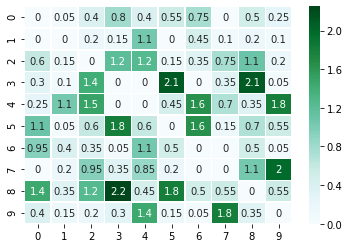

In [76]:
ax = sns.heatmap(final, linewidth=0.5, cmap=sns.color_palette("BuGn", 100), vmin=0, vmax=2.25, annot=True)

plt.show()

### 1.4 Hardest to Predict

#### Code used to identify the most frequently misidentified 
The code below has been commented out as the experiment was performed using a very large number of runs.
```python
err_Xs = []
err_yhats = []
```

```python
for run in range(100):

    # Split the data into 80% training, 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    # Initialise
    best_error = 500
    best_d = 0

    for d_ in range(1,8):
       
        error = 0 
        
        # Implement cross-validation
        kfold = KFold(5, True, 1)

        for train_index, test_index in kfold.split(X_train):
            Xtrain, Xtest = X_train[train_index], X_train[test_index]
            ytrain, ytest = y_train[train_index], y_train[test_index]
            clf = KernelPerceptron(Xtrain, ytrain, Xtest, ytest, kernel_type='p', d=d_, epochs=5)
            train_error = clf.train()
            error += clf.test()
        
        if error/5 < best_error:
            best_error = error/5
            best_d = d_
    
    # Once all the polynomial orders considered, retrain on full 80% using d*
    clf = KernelPerceptron(X_train, y_train, X_test, y_test, kernel_type='p', d=best_d, epochs=5)
    train_error = clf.train()
    test_error = clf.test()

    # Find indexes of training examples that have been misidentified
    y_hat = np.argmax(clf.GLBconfidence, axis=1)
    err_ind = [i for i, x in enumerate(y_hat!=y_train) if x]

    # Find the index of training examples in the X matrix
    for i in err_ind:
        err_Xs.append(np.where(np.all(X==X_train[i, :],axis=1))[0][0])
        err_yhats.append(y_hat[i])

    # Find indexes of test examples that have been misidentified
    y_hat_test = np.argmax(clf.GLBconfidence_test, axis=1)
    err_ind_test = [i for i, x in enumerate(y_hat_test!=y_test) if x]

    # Find the index of test examples in the X matrix
    for i in err_ind_test:
        err_Xs.append(np.where(np.all(X==X_test[i, :],axis=1))[0][0])
        err_yhats.append(y_hat_test[i])

# Find the most frequently mis-identified observations
counter = collections.Counter(err_Xs)

for i, pair in enumerate(counter.most_common(5)):
    print("Index of X: " + str(pair[0]) + " Count: " + str(pair[1]))

ind = np.zeros(5).astype(int)
for i in range(5):
    ind[i] = counter.most_common(5)[i][0]
```

In [466]:
counter.most_common(10)

[(5296, 639),
 (8261, 628),
 (2340, 397),
 (3637, 349),
 (2700, 335),
 (5145, 316),
 (6760, 309),
 (8670, 283),
 (8337, 259),
 (8285, 252)]

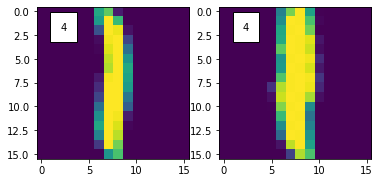

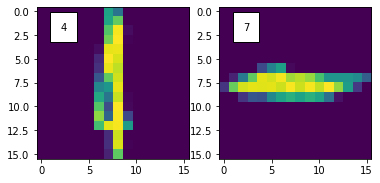

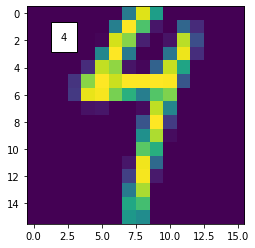

In [82]:
# Visualise

# Pick the top 5 
ind = [5296, 8261, 2340, 3637, 2700]
imgs = X[ind,:]

%matplotlib inline
f, ((ax0, ax1)) = plt.subplots(1,2)
ax0.imshow(imgs[0].reshape(16,16))
ax1.imshow(imgs[1].reshape(16,16))

f, ((ax2, ax3)) = plt.subplots(1,2)
ax2.imshow(imgs[2].reshape(16,16))
ax3.imshow(imgs[3].reshape(16,16))

f, ((ax4)) = plt.subplots(1,1)
ax4.imshow(imgs[4].reshape(16,16))

ax0.text(2, 2, str(int(y[ind[0]])), bbox={'facecolor': 'white', 'pad': 10})
ax1.text(2, 2, str(int(y[ind[1]])), bbox={'facecolor': 'white', 'pad': 10})
ax2.text(2, 2, str(int(y[ind[2]])), bbox={'facecolor': 'white', 'pad': 10})
ax3.text(2, 2, str(int(y[ind[3]])), bbox={'facecolor': 'white', 'pad': 10})
ax4.text(2, 2, str(int(y[ind[4]])), bbox={'facecolor': 'white', 'pad': 10});

### 1.5 Gaussian Kernel

### Finding a suitable range for s
Performing some heuristic experimentation over a wide range of values, we observe that a minimum lies somewhere in between 0.1 and 5

In [114]:
## Code used to explore heuristic ranges of s

train_errs = []
test_errs = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

trial_s = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

for d_ in trial_s:

    clf = KernelPerceptron(X_train, y_train, X_test, y_test, kernel_type='g', d=d_)
    train_error = clf.train()
    test_error = clf.test()
    train_errs.append(train_error)
    test_errs.append(test_error)
 

In [115]:
for i, s in enumerate(trial_s):
    print('S: ' + str(s) + " Train Error: " + str(train_errs[i]) + " Test Error: " + str(test_errs[i]))

S: 0.0001 Train Error: 0.14694810432912073 Test Error: 0.09838709677419355
S: 0.001 Train Error: 0.06668459263242807 Test Error: 0.05591397849462366
S: 0.01 Train Error: 0.0008066684592632429 Test Error: 0.026881720430107527
S: 0.1 Train Error: 0.0006722237160527024 Test Error: 0.05268817204301075
S: 1 Train Error: 0.0 Test Error: 0.06935483870967742
S: 10 Train Error: 0.0 Test Error: 0.18763440860215053
S: 100 Train Error: 0.0 Test Error: 0.7204301075268817


In [116]:
## Code used to explore heuristic ranges of s

train_errs = []
test_errs = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

trial_s = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

for d_ in trial_s:

    clf = KernelPerceptron(X_train, y_train, X_test, y_test, kernel_type='g', d=d_)
    train_error = clf.train()
    test_error = clf.test()
    train_errs.append(train_error)
    test_errs.append(test_error)
 

In [117]:
for i, s in enumerate(trial_s):
    print('S: ' + str(s) + " Train Error: " + str(train_errs[i]) + " Test Error: " + str(test_errs[i]))

S: 0.0001 Train Error: 0.15353589674643722 Test Error: 0.13978494623655913
S: 0.001 Train Error: 0.061172358160795914 Test Error: 0.060215053763440864
S: 0.005 Train Error: 0.005915568701263781 Test Error: 0.030107526881720432
S: 0.01 Train Error: 0.0005377789728421619 Test Error: 0.023118279569892472
S: 0.05 Train Error: 0.00013444474321054048 Test Error: 0.03602150537634408
S: 0.1 Train Error: 0.00040333422963162143 Test Error: 0.046236559139784944
S: 0.5 Train Error: 0.0 Test Error: 0.0521505376344086


### 2.1.1 Basic Results

In [83]:
## 20 runs for d = {1,..,8}

train_errors = []
train_sd = []
test_errors = []
test_sd = []
c_vals = []

s_range = [0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022]
for d_ in s_range:
    
    run_train_errors = []
    run_test_errors = []
    
    for run in range(20):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
        
        clf = KernelPerceptron(X_train, y_train, X_test, y_test, kernel_type='g', d=d_, epochs=5)
        train_error = clf.train()
        test_error = clf.test()
        run_train_errors.append(train_error)
        run_test_errors.append(test_error)
        
    train_errors.append(np.mean(run_train_errors))
    print("Polynomial order: " + str(d_) + " Average % train error: "+ str(np.mean(run_train_errors)))
    test_errors.append(np.mean(run_test_errors))
    test_sd.append(np.std(run_test_errors))
    train_sd.append(np.std(run_train_errors))
    c_vals.append(d_)

Polynomial order: 0.008 Average % train error: 0.15662812584027966
Polynomial order: 0.009 Average % train error: 0.12032804517343369
Polynomial order: 0.01 Average % train error: 0.09881688625974724
Polynomial order: 0.011 Average % train error: 0.08940575423500942
Polynomial order: 0.012 Average % train error: 0.06386125302500673
Polynomial order: 0.013 Average % train error: 0.0578112395805324
Polynomial order: 0.014 Average % train error: 0.05512234471632159
Polynomial order: 0.015 Average % train error: 0.05108900242000538
Polynomial order: 0.016 Average % train error: 0.041005646679214844
Polynomial order: 0.017 Average % train error: 0.04235009411132025
Polynomial order: 0.018 Average % train error: 0.05041677870395268
Polynomial order: 0.019 Average % train error: 0.03495563323474052
Polynomial order: 0.02 Average % train error: 0.03630008066684594
Polynomial order: 0.021 Average % train error: 0.03831675181500403
Polynomial order: 0.022 Average % train error: 0.034955633234740

In [84]:
# Create a df to store the error results
errors_df = pd.DataFrame()
errors_df['c'] = c_vals
errors_df['Train Error %'] = train_errors
errors_df['+/- Train %'] = train_sd
errors_df['Test Error %'] = test_errors
errors_df['+/- Test %'] = test_sd

In [85]:
errors_df

# Export to csv
errors_df.to_csv('errors_df_gaussian_1_v_all.csv',index=False)

In [88]:
errors_df

,c,Train Error %,+/- Train %,Test Error %,+/- Test %
0,0.008,0.156628,0.035893,2.930108,0.409274
1,0.009,0.120328,0.031090,3.077957,0.407992
2,0.010,0.098817,0.036144,2.680108,0.332845
3,0.011,0.089406,0.029232,2.658602,0.389729
4,0.012,0.063861,0.026508,2.758065,0.348468
5,0.013,0.057811,0.024460,2.599462,0.373366
6,0.014,0.055122,0.020785,2.682796,0.442660
7,0.015,0.051089,0.019296,2.559140,0.437239
8,0.016,0.041006,0.023082,2.599462,0.302357
9,0.017,0.042350,0.018666,2.545699,0.250029


### 1.2 Cross-Validation

In [86]:
d_stars = []
test_errors = []

for run in range(20):

    # Split the data into 80% training, 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    # Initialise
    best_error = 500
    best_d = 0

    s_range = [0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022]
    for d_ in s_range:
       
        error = 0 
        
        # Implement cross-validation
        kfold = KFold(5, True, 1)

        for train_index, test_index in kfold.split(X_train):
            Xtrain, Xtest = X_train[train_index], X_train[test_index]
            ytrain, ytest = y_train[train_index], y_train[test_index]
            clf = KernelPerceptron(Xtrain, ytrain, Xtest, ytest, kernel_type='g', d=d_, epochs=5)
            train_error = clf.train()
            error += clf.test()
        
        if error/5 < best_error:
            best_error = error/5
            best_d = d_
            
    # Once all the polynomial orders considered, retrain on full 80% using d*
    clf = KernelPerceptron(X_train, y_train, X_test, y_test, kernel_type='g', d=best_d, epochs=5)
    train_error = clf.train()
    test_error = clf.test()
    print("Run: " + str(run) + " Test Error: " + str(test_error) + " c*:  " + str(best_d))
    test_errors.append(test_error)
    d_stars.append(best_d)

Run: 0 Test Error: 2.4193548387096775 c*:  0.016
Run: 1 Test Error: 3.1720430107526885 c*:  0.014
Run: 2 Test Error: 3.010752688172043 c*:  0.022
Run: 3 Test Error: 2.6881720430107525 c*:  0.021
Run: 4 Test Error: 2.795698924731183 c*:  0.02
Run: 5 Test Error: 2.3655913978494625 c*:  0.019
Run: 6 Test Error: 2.741935483870968 c*:  0.018
Run: 7 Test Error: 2.795698924731183 c*:  0.021
Run: 8 Test Error: 2.849462365591398 c*:  0.016
Run: 9 Test Error: 2.1505376344086025 c*:  0.015
Run: 10 Test Error: 2.6344086021505375 c*:  0.016
Run: 11 Test Error: 2.903225806451613 c*:  0.019
Run: 12 Test Error: 1.935483870967742 c*:  0.018
Run: 13 Test Error: 1.935483870967742 c*:  0.017
Run: 14 Test Error: 2.3655913978494625 c*:  0.014
Run: 15 Test Error: 2.311827956989247 c*:  0.021
Run: 16 Test Error: 2.4193548387096775 c*:  0.017
Run: 17 Test Error: 2.043010752688172 c*:  0.015
Run: 18 Test Error: 2.6344086021505375 c*:  0.014
Run: 19 Test Error: 2.741935483870968 c*:  0.02


In [87]:
print("Mean test error: " + str(np.mean(test_errors)) + " +/- " + str(np.std(test_errors)))
print("Mean c*: " + str(np.mean(d_stars)) + " +/- " + str(np.std(d_stars)))

Mean test error: 2.545698924731183 +/- 0.34436942294080736
Mean c*: 0.017650000000000006 +/- 0.0025548972582082434
